### Execution environment
Since Jupyter notebookes work from a different directory the code block below changes the execution path to the root of the prject

In [21]:
from  ContextGenerator import key_context as context
import os
dir = os.getcwd()
if dir.split("/")[-3] == "codebase":
    os.chdir("../../")

In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tenseal as ts
import time


In [23]:
# importing module
import logging

# Create and configure logger
logging.basicConfig(
    filename="encrypted_evaluation.log", format="%(asctime)s %(message)s", filemode="a"
)


To create consistency of random events to make the project reproducible

In [24]:
torch.random.manual_seed(10)

Cookie Cutter LinearRegression Model

In [25]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


Train test split, It is imperative to understand why the x_test data is the **salary**. 

This is because the **salary** is sensitive data in this scenario there, it is going to be the inputs for our model thus making it the X value. We'll be mapping this **salary** to the expected years of experience.  

In [26]:
def test_train_split(df):
    training_data = df.sample(frac=0.8, random_state=25)  #
    testing_data = df.drop(training_data.index)
    y_train, x_train = (
        training_data["YearsExperience"].to_numpy(),
        training_data["Salary"].to_numpy(),
    )
    y_test, x_test = (
        testing_data["YearsExperience"].to_numpy(),
        testing_data["Salary"].to_numpy(),
    )
    return x_train, y_train, x_test, y_test


## Visualisation of the dataset.

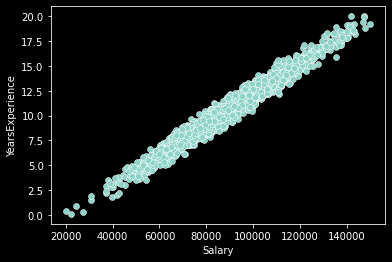

In [27]:
df = pd.read_csv("./LinearRegression/Data/Custom_Salary_Data.csv")
sns.scatterplot(data=df, x="Salary", y="YearsExperience")
plt.show()

In [28]:
x_train, y_train, x_test, y_test = test_train_split(df)
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


## Parameters
Outlined below is the parameters used for the PyTorch model.
It will be using: 
Mean Absolute Error, for the loss function
A learning rate of: 0.0000000005 | Which will be used for the stochastic gradient descent
The optimiser is stochastic gradient descent
Epochs: 100000, Number of iterations for the gradient descent

In [29]:
model = LinearRegressionModel(1, 1)  # single dimension
criterion = nn.MSELoss(reduction = "mean") # mean squared error, minimise total loss
#criterion = nn.L1Loss(reduction="mean")  # mean absolute error, minimise total loss
learning_rate = 5e-5
optimiser = torch.optim.SGD(
    model.parameters(), lr=learning_rate
)  # Stochastic Gradient Descent

EPOCHS = 100000
model = model.double()


In [30]:
# Convert numpy array to torch Variable
x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double()
y_test_tensor = torch.from_numpy(y_test).double()


In [31]:
def train(model, optimiser, criterion, inputs, labels, epochs=EPOCHS):
    for epoch in range(epochs + 1):
        # Forward to get output
        outputs = model(inputs)
        # Calculate Loss
        loss = criterion(outputs, labels)
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        
        ##Clip gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.8)
        
        
        optimiser.step()
        # Clear gradients w.r.t. parameters
        optimiser.zero_grad()
        if epoch % 10000 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))
        elif np.isnan(loss.item()):
            print("epoch {}, loss {}".format(epoch, loss.item()))
            break
        if loss.item() < 0.01:
            print("epoch {}, loss {}".format(epoch, loss.item()))
            break
    global Final_LOSS
    Final_LOSS = loss.item()
    return model


In [32]:
model = train(model, optimiser, criterion, x_train_tensor, y_train_tensor, EPOCHS)

epoch 0, loss 60507009.29665847
epoch 10000, loss 9.095455297960697
epoch 20000, loss 9.095454416684621
epoch 30000, loss 9.095453535410677
epoch 40000, loss 9.09545265413796
epoch 50000, loss 9.095451772866143
epoch 60000, loss 9.095450891594679
epoch 70000, loss 9.095450010322715
epoch 80000, loss 9.095449129050046
epoch 90000, loss 9.095448247774923
epoch 100000, loss 9.0954473664985


## Accuracy model
Outlined below is our accuracy model, it inputs our test set into the model, which is unseen to it.
Rounds it's estimate of the years of experience (nearest whole number) this individual has dependent on their salary, then comapares it with their actual experience

In [33]:
def accuracy(model, x, y):
    t_start = time.time()
    with torch.no_grad():  # no need to calculate gradients for testing
        y_pred_experience = model(x)
        y_pred_experience = torch.round(
            y_pred_experience, decimals=decimal_accuracy
        )  # nearest year experience rounded to whole number
        y_real_rounded = torch.round(
            y, decimals=decimal_accuracy
        )  # real salary (rounded unit: the thousands) LHS of the decimal
        accuracy = torch.eq(y_pred_experience, y_real_rounded)
    t_end = time.time()
    global duration
    duration = t_end - t_start
    return torch.sum(accuracy).item() / len(accuracy) * 100


In [34]:
decimal_accuracy = 1 #Acurracy to 1 decimal place
plain_accuracy = accuracy(model, x_test_tensor, y_test_tensor)
print(f"Accuracy on plain test_set: {plain_accuracy}, duration: {duration}")

Accuracy on plain test_set: 2.5, duration: 0.0007119178771972656


# Encrypted Wrapper
A wrapper class to provide Tenseal Capabilities to the Linear regression model

In [35]:
class EncryptedLR:
    def __init__(self, torch_linear_model):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_linear_model.linear.weight.data.tolist()[0]
        self.bias = torch_linear_model.linear.bias.data.tolist()
        

    def forward(self, enc_x):
        #Propogate the network
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


In [36]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    with torch.no_grad():
        y_pred_enc = model(enc_x_test)
        y_pred_output = y_pred_enc.decrypt()
        #Converting PlainTensor into pytorch tensor https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb
        y_pred_output = y_pred_output.tolist()
        y_pred_output = torch.FloatTensor(y_pred_output)
        ##################################################
        y_pred_output = torch.round(y_pred_output, decimals=decimal_accuracy)
        y_real_rounded = torch.round(y_test, decimals=decimal_accuracy) # Rounding the Years of experience to the nearest whole number
        y_real_rounded = torch.flatten(y_real_rounded)
        accuracy = torch.eq(y_pred_output, y_real_rounded)
    t_end = time.time()
    global encrypted_duration
    encrypted_duration = t_end - t_start
    correct_guess = torch.sum(accuracy).item()
    return correct_guess / len(accuracy) * 100


In [37]:
encrypted_linear_regression_model = EncryptedLR(model)
encrypted_x_test_tensor = ts.ckks_tensor(context, x_test_tensor.detach().numpy())

In [38]:
E_accuracy = encrypted_evaluation(
    encrypted_linear_regression_model, encrypted_x_test_tensor, y_test_tensor
)
print(f"Accuracy on encrypted test_set: {E_accuracy}, duration: {encrypted_duration}")


Accuracy on encrypted test_set: 0.25, duration: 0.7436466217041016


In [39]:
diff_accuracy = plain_accuracy - E_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print(
        "Oh! We got a better accuracy on the encrypted test-set! The noise was on our side..."
    )

Difference between plain and encrypted accuracies: 2.25


In [40]:
logger = logging.getLogger()
# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)
logger.debug(
    f"Epoch number:{EPOCHS} | Learning rate: {learning_rate} | Final Loss: {Final_LOSS} | Plain test_set accuracy: {plain_accuracy} | Encrypted test_set accuracy: {E_accuracy if E_accuracy != 0 else 'N/A'} | Decimal accuracty: {decimal_accuracy} | Duration: {duration} | Encrypted duration: {encrypted_duration}"
)
